# **Model for polarity**

In [9]:
from keras.layers.wrappers import Bidirectional

In [10]:
import tensorflow as tf

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, LSTM,Bidirectional,GlobalAveragePooling1D
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [12]:
!pip install contractions
import pandas as pd
import contractions
import nltk
from nltk.tokenize import word_tokenize
nltk.download('all')
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [13]:
!gdown --id 1oVHLl-SsEQ9q2PVDVRAwvYv91ks3lyur

Downloading...
From: https://drive.google.com/uc?id=1oVHLl-SsEQ9q2PVDVRAwvYv91ks3lyur
To: /content/GoogleNews-vectors-negative300.bin
3.64GB [00:39, 93.1MB/s]


In [80]:
#train
data = pd.read_csv('lab4_train.csv')

In [81]:
conflict_word_list = ['but','although','though','despie','spite','nevertheless','however','nonetheless','notwithstanding','contray','contrast']

def tokenize_filter(string_text):
  filter_words = []
  contracts = contractions.fix(string_text) #เปลี่ยนคำย่อ สมมติว่า didn't เป็น did not 
  token_list = word_tokenize(contracts)
  pos_sentences=nltk.pos_tag(token_list)
  for tup in pos_sentences:
      if tup[1].startswith(('J','N','R')) or tup[0] in conflict_word_list  : #เอา adj noun adv ไว้
        filter_words.append(tup[0])
  return filter_words

def lemma(string_text):
  lemma_word = []
  contracts = contractions.fix(string_text) #เปลี่ยนคำย่อ สมมติว่า didn't เป็น did not 
  doc = nlp(contracts)
  for token in doc:
      lemma_word.append(token.lemma_)
  return lemma_word

def lemma_filter(string_text):
  lemma_filter_list = []
  contracts = contractions.fix(string_text) #เปลี่ยนคำย่อ สมมติว่า didn't เป็น did not 
  doc = nlp(contracts)
  lemma = [token.lemma_ for token in doc]
  pos_sentences=nltk.pos_tag(lemma)
  for tup in pos_sentences:
      if tup[1].startswith(('J','N','R','V')) or tup[0] in conflict_word_list  : #เอา adj noun adv ไว้
        lemma_filter_list.append(tup[0])
  return lemma_filter_list

data['tokens'] = data['text'].apply(lemma_filter)

In [82]:
data['tokens'][10]

['-PRON-',
 'agree',
 'favorite',
 'be',
 'orrechiete',
 'sausage',
 'chicken',
 'usually',
 'waiter',
 'be',
 'kind',
 'enough',
 'split',
 'dish',
 'half',
 'so',
 '-PRON-',
 'get',
 'sample',
 'meat']

In [83]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [84]:
vocab_in_data = set()
for tokens in data['tokens']:
    for token in tokens:
        vocab_in_data.add(token)
print(len(vocab_in_data))

3546


In [85]:
vector_dim

300

In [86]:
max_len = 30

In [87]:
vocab_size = len(vocab_in_data) + 1

In [88]:
word_to_index = {'PADDING':0}

# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

for i, word in enumerate(vocab_in_data & set(model.vocab)):
    word_to_index[word] = i+1
    embedding_matrix[i+1] = model[word] 

In [89]:
import numpy as np
train, dev = np.split(data, [int(0.8 * len(data))])

In [90]:
def w2i(tokens):
    return [word_to_index.get(word, 0) for word in tokens[:max_len]]

# apply functions & convert to np.array
input_train = np.array(train['tokens'].apply(w2i).tolist())
input_dev = np.array(dev['tokens'].apply(w2i).tolist())
train_x = pad_sequences(input_train, max_len, padding='post')
dev_x = pad_sequences(input_dev, max_len, padding='post')

In [91]:
def relabel(label):
    return {'negative':0, 'positive':1, 'conflict':2, 'neutral':3}[label]
def reaspect(aspect):
    return {'service':0, 'food':1, 'anecdotes/miscellaneous':2, 'price':3,'ambience':4}[aspect]

In [92]:
# apply functions & convert to np.array
label_train = np.array(train['polarity'].apply(relabel).tolist())
label_dev = np.array(dev['polarity'].apply(relabel).tolist())

aspect_train = np.array(train['aspectCategory'].apply(reaspect).tolist())
aspect_dev = np.array(dev['aspectCategory'].apply(reaspect).tolist())

# label : one-hot vector
train_label = to_categorical(label_train, num_classes=4)
dev_label = to_categorical(label_dev, num_classes=4)

train_aspect = to_categorical(aspect_train, num_classes=5)
dev_aspect = to_categorical(aspect_dev, num_classes=5)

In [93]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
#print('label train:', train_y.shape)
#print('label dev:',dev_y.shape)

input train: (2524, 30)
input dev: (632, 30)


In [94]:
#Polarity
# instantiation
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=vocab_size,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=True,
                    trainable=True))

# average
model.add(Bidirectional(LSTM(200,dropout = 0.2,recurrent_dropout = 0.2)))

# add hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(50, activation='relu'))


# add output layer
model.add(Dense(4, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           1064100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               801600    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               205312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               102600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

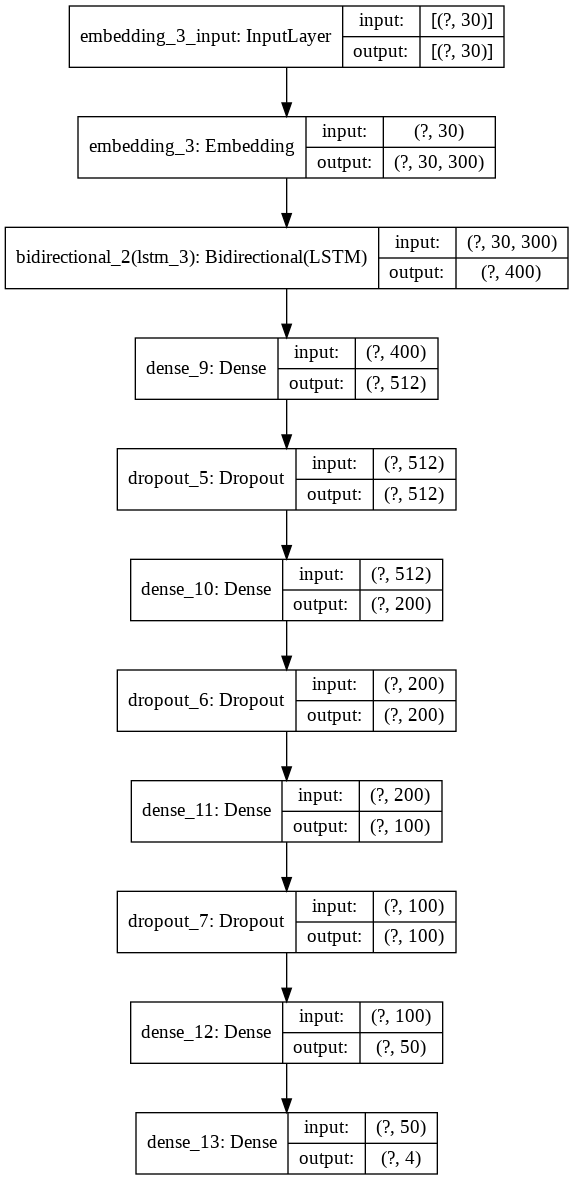

In [95]:
plot_model(model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [96]:
# train
history = model.fit(train_x, train_label, batch_size=128, epochs=12, validation_data=(dev_x, dev_label))

Epoch 1/12
20/20 [==============================] - 11s 544ms/step - loss: 1.0857 - accuracy: 0.5658 - val_loss: 0.8917 - val_accuracy: 0.6013
Epoch 2/12
20/20 [==============================] - 10s 503ms/step - loss: 0.9073 - accuracy: 0.6343 - val_loss: 0.8322 - val_accuracy: 0.6503
Epoch 3/12
20/20 [==============================] - 10s 505ms/step - loss: 0.8028 - accuracy: 0.6819 - val_loss: 0.7919 - val_accuracy: 0.6788
Epoch 4/12
20/20 [==============================] - 10s 510ms/step - loss: 0.7018 - accuracy: 0.7179 - val_loss: 0.8066 - val_accuracy: 0.6835
Epoch 5/12
20/20 [==============================] - 10s 509ms/step - loss: 0.6150 - accuracy: 0.7666 - val_loss: 0.8181 - val_accuracy: 0.6978
Epoch 6/12
20/20 [==============================] - 10s 516ms/step - loss: 0.5477 - accuracy: 0.7868 - val_loss: 1.0759 - val_accuracy: 0.6392
Epoch 7/12
20/20 [==============================] - 10s 516ms/step - loss: 0.4612 - accuracy: 0.8229 - val_loss: 0.9566 - val_accuracy: 0.6519

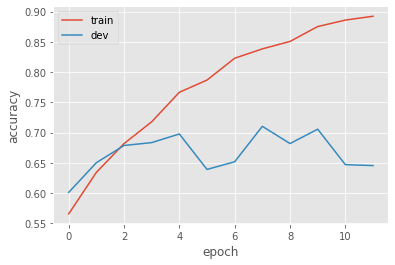

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [98]:
!gdown --id 1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_

Downloading...
From: https://drive.google.com/uc?id=1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_
To: /content/evaluate.py
100% 7.03k/7.03k [00:00<00:00, 11.3MB/s]


In [99]:
def index_to_label(polarity_index):
    return {0: 'negative', 1: 'positive', 2: 'conflict', 3: 'neutral'}[polarity_index]
def index_to_aspect(aspect_index):
    return {0:'service', 1:'food', 2:'anecdotes/miscellaneous', 3:'price',4:'ambience'}[aspect_index]


In [100]:
prediction = model.predict(dev_x)
prediction = [index_to_label(np.argmax(i)) for i in prediction]


In [101]:
newdf = pd.DataFrame()
newdf['id'] = dev['id']
newdf['aspectCategory'] = dev['aspectCategory'] #not predicted yet 
newdf['polarity'] = prediction
newdf.to_csv('pred.csv', index=None)
newdf

,id,aspectCategory,polarity
2524,3235,service,positive
2525,3480,anecdotes/miscellaneous,neutral
2526,1459,food,positive
2527,1459,anecdotes/miscellaneous,positive
2528,1597,food,positive
...,...,...,...
3151,2853,anecdotes/miscellaneous,positive
3152,1163,service,positive
3153,216,anecdotes/miscellaneous,positive
3154,1109,food,positive


In [102]:
!python3 evaluate.py lab4_train.csv pred.csv 

=== CLASSIFICATION : ASPECT ===
                class name  precision  recall  F1-score support
0                     food      1.000   1.000     1.000     203
1                    price      1.000   1.000     1.000      60
2                  service      1.000   1.000     1.000     104
3                 ambience      1.000   1.000     1.000      71
4  anecdotes/miscellaneous      1.000   1.000     1.000     194
5                MACRO AVG      1.000   1.000     1.000     632
6                MICRO AVG      1.000   1.000     1.000     632 

=== CLASSIFICATION : SENTIMENT ===
  class name  precision  recall  F1-score support
0   positive      0.833   0.784     0.808     306
1   negative      0.667   0.448     0.536     125
2    neutral      0.583   0.284     0.382      74
3   conflict      0.213   0.792     0.336      24
4  MACRO AVG      0.574   0.577     0.516     529
5  MICRO AVG      0.676   0.635     0.655     529 

=== CLASSIFICATION : OVERALL ===
              precision  recall  F

In [103]:
#Aspect
# instantiation
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=vocab_size,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=True,
                    trainable=True))

# average
model.add(Bidirectional(LSTM(200,recurrent_dropout = 0.2)))

# add hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))


# add output layer
model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 300)           1064100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               801600    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               205312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 2565      
Total params: 2,073,577
Trainable params: 2,073,577
Non-trainable params: 0
_________________________________________________________________


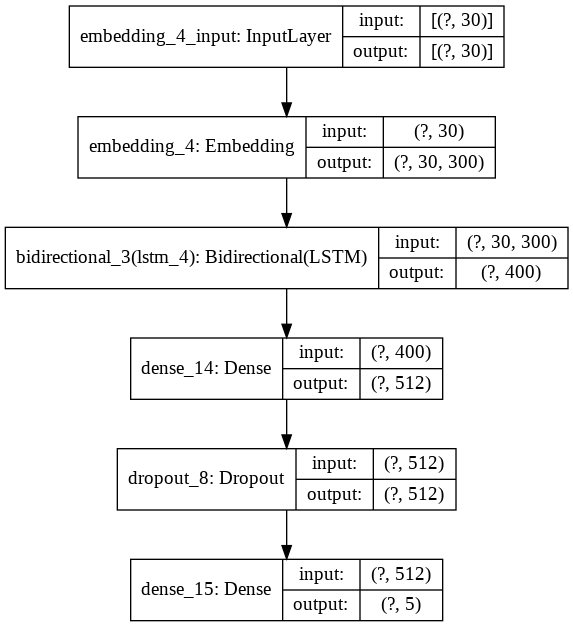

In [104]:
plot_model(model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [105]:
history = model.fit(train_x, train_aspect, batch_size=128, epochs=15, validation_data=(dev_x, dev_aspect))

Epoch 1/15
20/20 [==============================] - 9s 470ms/step - loss: 1.2783 - accuracy: 0.5226 - val_loss: 0.9952 - val_accuracy: 0.6456
Epoch 2/15
20/20 [==============================] - 9s 442ms/step - loss: 0.8784 - accuracy: 0.6696 - val_loss: 0.8969 - val_accuracy: 0.6566
Epoch 3/15
20/20 [==============================] - 9s 442ms/step - loss: 0.7054 - accuracy: 0.7258 - val_loss: 0.8402 - val_accuracy: 0.6772
Epoch 4/15
20/20 [==============================] - 9s 436ms/step - loss: 0.6247 - accuracy: 0.7357 - val_loss: 0.8163 - val_accuracy: 0.6788
Epoch 5/15
20/20 [==============================] - 9s 427ms/step - loss: 0.5546 - accuracy: 0.7575 - val_loss: 0.8578 - val_accuracy: 0.6741
Epoch 6/15
20/20 [==============================] - 9s 434ms/step - loss: 0.4941 - accuracy: 0.7730 - val_loss: 0.9550 - val_accuracy: 0.6677
Epoch 7/15
20/20 [==============================] - 9s 433ms/step - loss: 0.4690 - accuracy: 0.7750 - val_loss: 0.9032 - val_accuracy: 0.6725
Epoch 

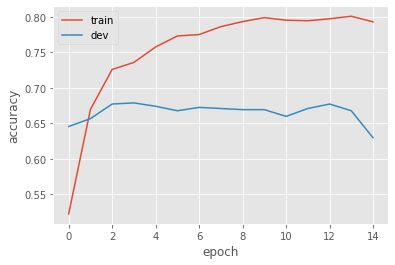

In [106]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [107]:
prediction = model.predict(dev_x)
prediction = [index_to_aspect(np.argmax(i)) for i in prediction]

In [108]:
aspect_file = pd.DataFrame()
aspect_file['id'] = dev['id']
aspect_file['polarity'] = dev['polarity'] #not predicted yet 
aspect_file['aspectCategory'] = prediction
aspect_file.to_csv('asp_pred.csv', index=None)
aspect_file

,id,polarity,aspectCategory
2524,3235,positive,service
2525,3480,negative,anecdotes/miscellaneous
2526,1459,positive,food
2527,1459,positive,food
2528,1597,positive,food
...,...,...,...
3151,2853,positive,anecdotes/miscellaneous
3152,1163,positive,service
3153,216,positive,anecdotes/miscellaneous
3154,1109,positive,food


In [109]:
!python3 evaluate.py lab4_train.csv asp_pred.csv

=== CLASSIFICATION : ASPECT ===
                class name  precision  recall  F1-score support
0                     food      0.878   0.744     0.805     203
1                    price      0.762   0.267     0.395      60
2                  service      0.688   0.827     0.751     104
3                 ambience      0.667   0.592     0.627      71
4  anecdotes/miscellaneous      0.888   0.531     0.665     194
5                MACRO AVG      0.776   0.592     0.649     632
6                MICRO AVG      0.801   0.630     0.705     632 

=== CLASSIFICATION : SENTIMENT ===
  class name  precision  recall  F1-score support
0   positive      1.000   1.000     1.000     306
1   negative      1.000   1.000     1.000     125
2    neutral      1.000   1.000     1.000      74
3   conflict      1.000   1.000     1.000      24
4  MACRO AVG      1.000   1.000     1.000     529
5  MICRO AVG      1.000   1.000     1.000     529 

=== CLASSIFICATION : OVERALL ===
              precision  recall  F